# Image Classification using convolutional layers with PyTorch
In this notebook, a Convolutional Neural Network will be build from scratch and trained on the MNIST dataset. The MNIST dataset is a dataset containing hand-written images of digits. The end goal is to label the images with their corresponding digit. Take a look at the Feedforward Neural Network Image Classification of the MNIST dataset for the exploring of the MNIST dataset and the explanation about the data preparation.    

In [1]:
# Imports
import copy
import torch
import random
import numpy as np
import torch.nn as nn 
from torch.optim import SGD 
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
from torchmetrics.classification import MulticlassAccuracy 
from torch.utils.data import Dataset, DataLoader, random_split

## Dataset preparation
In this part, the dataset is loaded and a preview of an image is shown. The training set (train=true) and test set (train=false) are loaded from the default datasets offered by PyTorch. When loading a dataset like this, images can already be transformed. In order for an image to be processed by a neural network, it always needs to be converted to a Tensor. Also when training neural networks, it is good practice to normalize the images to speed up the training process. We do this by defining the transforms and passing them to the dataset downloader.

In [2]:
# Define transforms that will be applied to the downloaded images
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

# Load MNIST training and test dataset
mnist_trainset = datasets.MNIST(root='../../data', train=True, download=False, transform=transform)
mnist_testset = datasets.MNIST(root='../../data', train=False, download=False, transform=transform)

In PyTorch, data can be extracted from the dataset using data loaders. These loaders can extract the data in batches and can also do this in a random fashion to prevent repetition in the data. The size of the batch can be passed as a parameter.

In [3]:
# Create dataloaders
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)
valid_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

# Create a total dataloader dictionary
dataloaders = {'train': train_loader, 'valid': valid_loader}

## Creating the neural network model class
In this section, a definition of the Neural Network will be created. In this example, two convolutional layers followed by a ReLU non-linearity and average pooling are the first part of the Convolutional Neural Network. The last part is the flattening of the feature maps followed by the linear layers.

In [4]:
class NeuralNet(nn.Module):

    def __init__(self):
        super().__init__()

        # Convolutional layer where the input image will be converted to 16 feature maps
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=1, padding=2),
            nn.ReLU(), # ReLU activation
            nn.AvgPool2d(2, stride=2) # Average pooling layer
        )

        # Convolutional layer where the previous 16 feature maps will be converted to 32 feature maps
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32 , 5, stride=1, padding=2),
            nn.ReLU(), # ReLU activation
            nn.AvgPool2d(2, stride=2) # Average pooling layer
        )

        # Output layer where the 32 feature maps get flattened to a vector of 10
        self.out = nn.Linear(32*7*7,10)

    # This function executs the forward pass of an image x to the neural net
    def forward(self,x):
        x = self.conv1(x) # Passing the input image through the first convolutional layer
        x = self.conv2(x) # Passing the resulting feature maps through the second convolutional layer
        x = x.view(x.size(0),-1) # The output of the last convolutional layer is flattened (batch size, 32x7x7)
        x = self.out(x)
        return x

# Create the neural net object
model = NeuralNet()

## Model training
A function is created to automate the training of the Convolutional Neural Network.

In [5]:
# Search for the available training device on the computer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
def train_model(model, optimizer, criterium, n_epochs=20):

    # Learning curves
    results = {"training_acc": [], "training_loss": [], "validation_acc": [], "validation_loss": []}

    # Loop over all epochs
    best_loss = float('inf')
    for epoch in range(n_epochs):

        # Debug
        print('Epoch {}/{}'.format(epoch+1, n_epochs))
        print('-'*10)

        # Each epoch has a training and validation phase
        for phase in ['train','valid']:

            # Set the network state dependent on the phase
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Reset the losses and corrects at the start of each epoch
            running_loss = 0.0
            running_corrects = 0.0

            # Extract batches from the data loaders untill all batches are retrieved
            num_samples = 0
            for inputs, labels in dataloaders[phase]:

                # Inputs shape
                batch_size, c, h, w = inputs.shape

                # Store the inputs and labels to the selected device
                inputs = inputs.to(device)  
                labels = labels.to(device)  

                # Forward pass through the network
                outputs = model(inputs)

                # Softmax transforms the output probabilities into one selected class
                _, class_pred = torch.max(outputs, 1)

                # Compute the loss of the batch
                loss = criterium(outputs, labels)
                
                # Update the losses and corrects for this batch
                running_loss += loss.item() * batch_size
                running_corrects += class_pred.eq(labels).sum().item()

                # Calculate total samples
                num_samples += batch_size

                # If in training phase, adapt the model paramters to account for the losses
                if phase=='train':
                    optimizer.zero_grad() # Pytorch keeps track of the gradients over multiple epochs, therefore initialise it to 0
                    loss.backward() # Calculate the weight gradients (Backward Propagation)
                    optimizer.step() # Update the model parameters using the defined optimizer 
                    
            # Save results
            if phase == 'train':
                results['training_acc'].append((running_corrects/num_samples)*100)
                results['training_loss'].append(running_loss/num_samples)
                print("train_acc %.3f train_loss %.3f" % (running_corrects/num_samples, running_loss/num_samples))
            elif phase == 'valid':
                results['validation_acc'].append((running_corrects/num_samples)*100)
                results['validation_loss'].append(running_loss/num_samples)
                print("val_acc %.3f val_loss %.3f" % (running_corrects/num_samples, running_loss/num_samples))

        # Save model
        if loss < best_loss:
            torch.save(model, '../../models/classification_model.pt')
            best_loss = loss

    return results


In [7]:
# Set model to device
model.to(device)

# Set the optimizer
optimizer = SGD(model.parameters(), lr=0.001)

# Set the loss function
criterium = nn.CrossEntropyLoss()

# Train for 50 epochs
results = train_model(model, optimizer, criterium, n_epochs=10)

Epoch 1/10
----------


train_acc 0.664 train_loss 1.080


val_acc 0.867 val_loss 0.421
Epoch 2/10
----------


train_acc 0.891 train_loss 0.356


val_acc 0.918 val_loss 0.282
Epoch 3/10
----------


train_acc 0.918 train_loss 0.276


val_acc 0.935 val_loss 0.229
Epoch 4/10
----------


train_acc 0.934 train_loss 0.220


val_acc 0.947 val_loss 0.182
Epoch 5/10
----------


train_acc 0.948 train_loss 0.180


val_acc 0.957 val_loss 0.147
Epoch 6/10
----------


train_acc 0.956 train_loss 0.152


val_acc 0.961 val_loss 0.128
Epoch 7/10
----------


train_acc 0.962 train_loss 0.132


val_acc 0.968 val_loss 0.109
Epoch 8/10
----------


train_acc 0.966 train_loss 0.118


val_acc 0.966 val_loss 0.103
Epoch 9/10
----------


train_acc 0.969 train_loss 0.106


val_acc 0.972 val_loss 0.098
Epoch 10/10
----------


train_acc 0.971 train_loss 0.099


val_acc 0.974 val_loss 0.082


The training and validation loss are plotted for each epoch during the training procedure. It is clear that the loss becomes smaller as the amount of epochs progresses. The validation loss keeps decreasing, thus overfitting does not occur here.

Text(0.5, 1.0, 'Accuracy')

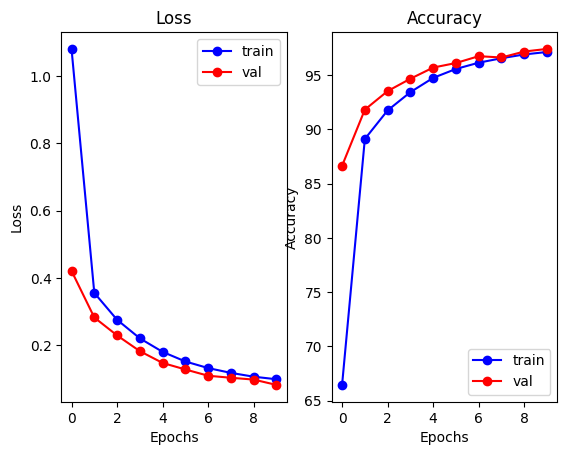

In [8]:
# Plot results
plt.subplot(1, 2, 1)
plt.plot(range(len(results['training_loss'])), results['training_loss'], 'bo-', label='train')
plt.plot(range(len(results['validation_loss'])), results['validation_loss'], 'ro-', label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(len(results['training_acc'])), results['training_acc'], 'bo-', label='train')
plt.plot(range(len(results['validation_acc'])), results['validation_acc'], 'ro-', label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')

## Model validation

To validate the model we can compare the predicted value of an image to the ground thruth. We can do this for the first batch. 

In [9]:
# Extract a batch
batch = next(iter(train_loader))

# Extract the images and labels
x, y = batch

# Get the predictions for the whole batch
y_pred = model(x).argmax(axis=1)

# Plot predictions and labels
fig, ax = plt.subplots(2,5,figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x[i].permute(1,2,0), cmap='gray')
    plt.title(f'Predicted Digit: {y_pred[i]}')
plt.show()

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [18]:
# Reset the losses and corrects at the start of each epoch
running_corrects = 0.0

# Extract batches from the data loaders untill all batches are retrieved
num_samples = 0
for inputs, labels in valid_loader:

    # Inputs shape
    batch_size, c, h, w = inputs.shape

    # Store the inputs and labels to the selected device
    inputs = inputs.to(device)  
    labels = labels.to(device)  

    # Forward pass through the network
    outputs = model(inputs)

    # Softmax transforms the output probabilities into one selected class
    _, class_pred = torch.max(outputs, 1)
    
    # Update the losses and corrects for this batch
    running_corrects += class_pred.eq(labels).sum().item()

    # Calculate total samples
    num_samples += batch_size

# Print results
print('The model has an accuracy of ' + str((running_corrects/num_samples)*100) + ' on the validation set.')

The model has an accuracy of 96.7 on the validation set.
